# Import Modules

In [1]:
import requests
import requests_cache
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import re

from collections import Counter

import gensim
from gensim import corpora
from wordcloud import WordCloud

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Download NLTK Packages
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aadhilmsyed839/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/aadhilmsyed83

True

# Scrape Data from Business Insider

In [4]:
# Enable caching
requests_cache.install_cache('business_insider_cache', expire_after=3600)  # Cache expires after 1 hour

In [5]:
# List of categories to scrape
categories = [
    "business", "defense", "tech", "finance", "strategy",
    "politics", "retail", "travel", "science", "sports",
    "artificial-intelligence", "media", "advertising",
    "transportation", "law", "entertainment", "startups",
    "healthcare", "careers", "health", "economy", "innovation",
    "markets", "reviews", "personal-finance", "real-estate",
    "smallbusiness", "sustainability", "enterprise", "culture"
]

# Remove duplicates
categories = list(set(categories))

# Base URL
base_url = "https://www.businessinsider.com"

# Initialize lists to store the data
titles, urls, categories_list = [], [], []

In [6]:
# Iterate over each category
for idx, category in enumerate(categories):
    print(f"({idx + 1}/{len(categories)}) Scraping category: {category}")
    # Fetch the page
    response = requests.get(f"{base_url}/{category}")
    if response.status_code != 200:
        print(f"Failed to retrieve {category} category page.")
        continue

    # Parse the page content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all article containers
    articles = soup.find_all('article')  # Adjust selector if necessary

    for article in articles:
        # Extract title
        title = article.find('h3', class_='tout-title')
        if title:
            titles.append(title.text.strip())
            categories_list.append(category)  # Store the category
            
            # Extract URL from the associated <a> tag
            link = title.find('a', href=True)
            if link and 'href' in link.attrs:
                url = link['href']
                # Convert relative URL to absolute
                if not url.startswith("http"):
                    url = f"{base_url}{url}"
                urls.append(url)
            else:
                urls.append('N/A')
        else:
            titles.append('N/A')
            urls.append('N/A')
            categories_list.append(category)

(1/30) Scraping category: sports
(2/30) Scraping category: defense
(3/30) Scraping category: politics
(4/30) Scraping category: entertainment
(5/30) Scraping category: travel
(6/30) Scraping category: business
(7/30) Scraping category: law
(8/30) Scraping category: healthcare
(9/30) Scraping category: enterprise
(10/30) Scraping category: economy
(11/30) Scraping category: smallbusiness
(12/30) Scraping category: startups
(13/30) Scraping category: reviews
(14/30) Scraping category: media
(15/30) Scraping category: finance
(16/30) Scraping category: transportation
(17/30) Scraping category: strategy
(18/30) Scraping category: markets
(19/30) Scraping category: science
(20/30) Scraping category: advertising
(21/30) Scraping category: retail
(22/30) Scraping category: culture
(23/30) Scraping category: health
(24/30) Scraping category: personal-finance
(25/30) Scraping category: careers
(26/30) Scraping category: tech
(27/30) Scraping category: artificial-intelligence
(28/30) Scraping ca

In [7]:
# Create a DataFrame
df = pd.DataFrame({
    'Category': categories_list,
    'Title': titles,
    'URL': urls
})

df# Remove duplicates based on 'Title' and 'URL'
df = df.drop_duplicates(subset=['Title', 'URL'], keep='first')

# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

Scraping complete. Data saved to us_articles.csv


# Preprocess Category Names

In [8]:
# Mapping of old categories to new broader categories
category_mapping = {
    # Industries
    "business": "Industries",
    "retail": "Industries",
    "media": "Industries",
    "advertising": "Industries",
    "transportation": "Industries",
    "entertainment": "Industries",
    "startups": "Industries",
    "careers": "Industries",
    "healthcare": "Industries",
    "sports": "Industries",
    "smallbusiness": "Industries",
    "culture": "Industries",

    # Technology
    "tech": "Technology",
    "science": "Technology",
    "artificial-intelligence": "Technology",
    "innovation": "Technology",
    "sustainability": "Technology",
    "enterprise": "Technology",
    "startups": "Technology",  # Also overlaps with Industries

    # Economy & Trade
    "economy": "Economy & Trade",
    "finance": "Economy & Trade",
    "strategy": "Economy & Trade",
    "markets": "Economy & Trade",
    "real-estate": "Economy & Trade",
    "personal-finance": "Economy & Trade",

    # Legal & Regulatory
    "defense": "Legal & Regulatory",
    "politics": "Legal & Regulatory",
    "law": "Legal & Regulatory"
}


# Default to "Other" for any unmapped categories
default_category = "Other"

# Apply the mapping to the 'Category' column
df['Category'] = df['Category'].apply(
    lambda x: category_mapping.get(x.lower(), default_category)
)

# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

Scraping complete. Data saved to us_articles.csv


In [9]:
df

,Category,Title,URL
0,Industries,I've skied at over 20 resorts in the US. Many ...,https://www.businessinsider.com/popular-ski-re...
1,Industries,Best sports streaming services: Watch live gam...,https://www.businessinsider.com/guides/streami...
2,Industries,Netflix's Jake Paul vs. Mike Tyson fight showe...,https://www.businessinsider.com/jake-paul-mike...
3,Industries,I've been skiing and snowboarding my whole lif...,https://www.businessinsider.com/best-tips-firs...
4,Industries,I've been playing golf my whole life. The game...,https://www.businessinsider.com/golf-taught-me...
...,...,...,...
1445,Technology,Sweeping changes to America's aging power grid...,https://www.businessinsider.com/power-grid-tra...
1446,Technology,A new sail design for cargo ships is propellin...,https://www.businessinsider.com/sc/a-new-sail-...
1447,Technology,Biden's tariffs don't loosen China's grip on o...,https://www.businessinsider.com/bidens-tariffs...
1448,Technology,There's a simple solution to make wine more su...,https://www.businessinsider.com/wine-environme...


In [10]:
df.shape

(1212, 3)

# Scrape Individual Article

This may take up to 15 minutes

In [11]:
import time
import pandas as pd
from bs4 import BeautifulSoup
import requests

# Function to scrape additional details from each article URL
def scrape_article_details(row):
    try:
        # Fetch the article page
        time.sleep(0.05)  # Add delay to avoid overloading the server
        print(f"Now Processing {row['URL']}")
        response = requests.get(row['URL'])
        if response.status_code != 200:
            return pd.Series([None, None, None, None, None])  # Return None if the page isn't available
        
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract author
        author = soup.find('meta', {'property': 'author'}) or soup.find('meta', {'name': 'author'})
        author = author['content'] if author else None
        
        # Extract publication date
        date = soup.find('meta', {'name': 'datePublished'})
        date = date['content'] if date else None
        
        # Extract content (join all <p> tags' text content)
        article_body = soup.find_all('p')
        content = ' '.join(p.get_text() for p in article_body if p.get_text())
        
        # Extract keywords
        keywords = soup.find('meta', {'name': 'news_keywords'}) or soup.find('meta', {'property': 'keywords'})
        keywords = keywords['content'] if keywords else None
        
        # Extract description
        description = soup.find('meta', {'name': 'description'}) or soup.find('meta', {'property': 'og:description'})
        description = description['content'] if description else None
        
        return pd.Series([author, date, content, keywords, description])
    except Exception as e:
        print(f"Error processing URL {row['URL']}: {e}")
        return pd.Series([None, None, None, None, None])

In [12]:
# Apply the function to the DataFrame
print("Scraping article details. This may take some time...")
df[['Author', 'Date', 'Content', 'Keywords', 'Description']] = df.apply(scrape_article_details, axis=1)

Scraping article details. This may take some time...
Now Processing https://www.businessinsider.com/popular-ski-resort-would-not-visit-utah-brighton-review-2024-12
Now Processing https://www.businessinsider.com/guides/streaming/best-sports-streaming-services-apps-live
Now Processing https://www.businessinsider.com/jake-paul-mike-tyson-netflix-influencer-explained-2024-11
Now Processing https://www.businessinsider.com/best-tips-first-time-skiing-snowboarding-longtime-expert
Now Processing https://www.businessinsider.com/golf-taught-me-how-to-regulate-my-emotions-mental-health-2024-12
Now Processing https://www.businessinsider.com/guides/streaming/free-qatar-f1-live-stream-where-to-watch-formula-one-2024
Now Processing https://www.businessinsider.com/guides/streaming/how-to-watch-thanksgiving-football-2024
Now Processing https://www.businessinsider.com/woman-golfer-sexism-makes-her-not-want-to-play-strangers-2024-11
Now Processing https://www.businessinsider.com/guides/streaming/free-f1-

Now Processing https://www.businessinsider.com/zelenskyy-suggests-plan-to-end-hot-phase-russia-ukraine-war-2024-11
Now Processing https://www.businessinsider.com/oreshnik-missile-new-details-putin-russia-ukraine-hypersonic-2024
Now Processing https://www.businessinsider.com/ukraine-navy-uses-dazzle-camouflage-boats-confuse-russia-world-war-2024-11
Now Processing https://www.businessinsider.com/israel-air-defense-system-vulnerable-drones-2024-11
Now Processing https://www.businessinsider.com/us-military-fight-with-houthis-is-locked-in-dangerous-stalemate-2024-11
Now Processing https://www.businessinsider.com/counter-drone-defense-technology-system-companies-2024-11
Now Processing https://www.businessinsider.com/autopilot-error-caused-new-zealand-navy-ship-sink-off-samoa-2024-11
Now Processing https://www.businessinsider.com/why-chinas-df-26-missile-so-dangerous-for-us-military-2024-11
Now Processing https://www.businessinsider.com/israel-arrow-3-missile-defense-system-europe-russia-2024

Now Processing https://www.businessinsider.com/best-and-worst-pants-trends-stylists-2025
Now Processing https://www.businessinsider.com/leaving-law-for-tv-writing-interior-chinatown-charles-yu-interview-2024-12
Now Processing https://www.businessinsider.com/taylor-swift-book-self-published-launch-success-2024-12
Now Processing https://www.businessinsider.com/robert-redford-selling-california-home-spend-time-new-mexico-utah-2024-12
Now Processing https://www.businessinsider.com/spotify-wrapped-data-sharing-game-tinder-duolingo-starbucks-2024-12
Now Processing https://www.businessinsider.com/khloe-kardashians-tip-for-turning-40-shedding-30s-2024-12
Now Processing https://www.businessinsider.com/nicole-kidman-career-over-at-40-2024-12
Now Processing https://www.businessinsider.com/every-no-1-song-debut-billboard-hot-100
Now Processing https://www.businessinsider.com/jennifer-tilly-the-simpsons-worth-divorce-settlement-2024-12
Now Processing https://www.businessinsider.com/taylor-swift-era

Now Processing https://www.businessinsider.com/places-in-the-us-everyone-should-see-from-frequent-traveler
Now Processing https://www.businessinsider.com/guides/deals/cyber-monday-luggage-deals-2024-12
Now Processing https://www.businessinsider.com/families-different-vacation-styles-group-trip-pros-cons-2024-11
Now Processing https://www.businessinsider.com/traveling-world-5-years-top-tips-asia-latin-america-europe-2024-11
Now Processing https://www.businessinsider.com/packing-guide-safari-vacation-east-africa-tanzania-2024-12
Now Processing https://www.businessinsider.com/top-50-countries-tourism-ranked-worst-to-best-frequent-traveler-2024-12
Now Processing https://www.businessinsider.com/royal-caribbeans-utopia-of-the-seas-cruise-ship-top-amenities-2024-12
Now Processing https://www.businessinsider.com/digital-nomad-visas-countries
Now Processing https://www.businessinsider.com/skipped-paris-visited-bordeaux-less-crowds-great-shopping-winter-2024-11
Now Processing https://www.busines

Now Processing https://www.businessinsider.com/doj-officials-urge-judge-order-google-sell-chrome-search-antitrust-2024-11
Now Processing https://www.businessinsider.com/doge-takeaways-musk-ramaswamy-budget-cuts-reform-wsj-oped-2024-11
Now Processing https://www.businessinsider.com/trump-demands-immediate-dismissal-of-hush-money-case-2024-11
Now Processing https://www.businessinsider.com/diddy-seek-sex-trafficking-dismissal-after-feds-to-do-list-2024-11
Now Processing https://www.businessinsider.com/trump-hush-money-sentencing-decision-looms-2024-11
Now Processing https://www.businessinsider.com/woman-claimed-moms-hurricane-aid-blamed-botox-youthful-look-police-2024-11
Now Processing https://www.businessinsider.com/diddy-hand-written-notes-swiped-jail-cell-2024-11
Now Processing https://www.businessinsider.com/democrats-trump-blue-state-fight-agenda-courts-2024-11
Now Processing https://www.businessinsider.com/disney-uber-arbitration-fine-print-jury-trials-2024-11
Now Processing https:/

Now Processing https://www.businessinsider.com/crowdstrike-mass-it-outage-us-hospitals-cancel-some-surgeries-procedures-2024-7
Now Processing https://www.businessinsider.com/pitch-deck-thoughtful-ai-20-million-drive-capital-series-a-2024-7
Now Processing https://www.businessinsider.com/longevity-trainer-fitness-markers-to-watch-for-a-longer-life-2024-7
Now Processing https://www.businessinsider.com/pharmacy-fired-staff-hemophilia-medication-eeoc-factor-one-lawsuit-ada-2024-6
Now Processing https://www.businessinsider.com/unregulated-life-coaching-industry-haven-disgraced-therapists-2024-6
Now Processing https://www.businessinsider.com/a16z-knownwell-buying-weight-loss-alfie-health-obesity-2024-6
Now Processing https://www.businessinsider.com/us-doctors-warn-against-glp1s-wegovy-ozempic-children-2024-6
Now Processing https://www.businessinsider.com/conservatives-southern-baptist-embryonic-personhood-ivf-access-2024-6
Now Processing https://www.businessinsider.com/teledermatology-future-

Now Processing https://www.businessinsider.com/american-dream-buying-home-homeownership-difficult-2024-11
Now Processing https://www.businessinsider.com/boomer-moved-panama-california-struggling-find-remote-job-side-husltes-2024-11
Now Processing https://www.businessinsider.com/remote-work-side-hustles-commute-uber-etsy-in-person-hybrid-2024-11
Now Processing https://www.businessinsider.com/black-friday-spending-record-inflation-electronics-toys-thanksgiving-cyber-monday-2024-11
Now Processing https://www.businessinsider.com/vibecession-when-will-the-economy-get-better-inflation-recession-trump-2024-11
Now Processing https://www.businessinsider.com/russia-ruble-dollar-currency-putin-ukraine-war-economy-inflation-military-2024-11
Now Processing https://www.businessinsider.com/splintered-social-media-authentic-breed-of-influencer-2024-11
Now Processing https://www.businessinsider.com/what-are-tariffs
Now Processing https://www.businessinsider.com/waymo-robotaxis-competing-uber-lyft-drive

Now Processing https://www.businessinsider.com/pitch-and-run-creating-community-founders-vcs-connect-over-exercise-2024-11
Now Processing https://www.businessinsider.com/vc-firm-insight-partners-how-to-incorporate-generative-ai-2024-11
Now Processing https://www.businessinsider.com/pyannoteai-funding-voice-ai-france-2024-11
Now Processing https://www.businessinsider.com/how-trump-tariffs-could-impact-hardware-consumer-goods-startups-2024-11
Now Processing https://www.businessinsider.com/voice-cloning-startup-elevenlabs-raising-funding-valuation-2024-11
Now Processing https://www.businessinsider.com/cathie-wood-ark-venture-fund-elon-musk-startups-2024-11
Now Processing https://www.businessinsider.com/pruna-ai-models-compress-funding-pitch-deck-2024-11
Now Processing https://www.businessinsider.com/startups-jd-vance-invested-in-venture-capital-narya-peter-thiel-2024-11
Now Processing https://www.businessinsider.com/jeff-bezos-just-invested-in-laundry-folding-robots-2024-11
Now Processing

Now Processing https://www.businessinsider.com/netflix-live-streaming-wars-won-password-how-2024-11
Now Processing https://www.businessinsider.com/netflix-stat-shows-why-it-could-raise-prices-2024-12
Now Processing https://www.businessinsider.com/tiktok-drove-100-million-in-us-black-friday-sales-livestream-2024-12
Now Processing https://www.businessinsider.com/tips-create-tiktok-content-get-views-money-creator-manager-2024-11
Now Processing https://www.businessinsider.com/best-dating-apps-changing-new-startups-take-on-tinder-hinge
Now Processing https://www.businessinsider.com/404-media-jason-koebler-interview-2024-12
Now Processing https://www.businessinsider.com/disney-bob-iger-ceo-diet-exercise-workout-routine-leadership-management-2024-11
Now Processing https://www.businessinsider.com/tiktok-ban-details-when-how-legal-cases-trump-options
Now Processing https://www.businessinsider.com/disney-bob-iger-biggest-wins-proxy-battle-box-office-turnaround-2024-11
Now Processing https://www.

Now Processing https://www.businessinsider.com/cybertruck-schedule-change-battery-supply-issue-workers-say-2024-12
Now Processing https://www.businessinsider.com/stellantis-ceo-resignation-board-disagreements-dealers-optimistic-2024-12
Now Processing https://www.businessinsider.com/general-motors-china-writedown-saic-joint-venture-ev-2024-12
Now Processing https://www.businessinsider.com/lawsuit-says-air-france-passenger-injured-seat-broke-during-takeoff-2024-12
Now Processing https://www.businessinsider.com/china-ev-byd-zeekr-turning-hybrids-bypass-tariffs-2024-12
Now Processing https://www.businessinsider.com/elon-musk-tesla-pay-package-next-steps-appeal-2024-12
Now Processing https://www.businessinsider.com/elon-musk-tesla-stock-price-outlook-tsla-trump-doge-gerber-2024-11
Now Processing https://www.businessinsider.com/auto-industry-major-challenges-stellantis-ceo-resigns-ev-tariffs-competition-2024-12
Now Processing https://www.businessinsider.com/american-airlines-737-made-emergen

Now Processing https://www.businessinsider.com/leaders-discuss-ai-technology-transform-company-workflows-unlock-employee-potential-2024-10
Now Processing https://www.businessinsider.com/ipo-experts-finance-legal-strategy-tips-public-market-company-shares-2024-9
Now Processing https://www.businessinsider.com/truth-promotions-companies-picking-managers-wrong-new-study-2024-9
Now Processing https://www.businessinsider.com/snap-evan-spiegel-feedback-uncomfortable-conversations-2024-9
Now Processing https://www.businessinsider.com/cyber-insurance-coverage-plan-benefits-costs
Now Processing https://www.businessinsider.com/mark-zuckerberg-flatter-org-chart-middle-managers-comments-2024-9
Now Processing https://www.businessinsider.com/what-is-data-security-posture-management
Now Processing https://www.businessinsider.com/ibm-exec-companies-focus-training-employees-ai-skills-tech-impact-2024-9
Now Processing https://www.businessinsider.com/how-to-respond-to-ransomware-attack
Now Processing http

Now Processing https://www.businessinsider.com/nyt-post-election-memo-trump-coverage-unflinching-fair-2024-11
Now Processing https://www.businessinsider.com/new-york-times-tech-workers-cross-picket-line-election-strike-2024-11
Now Processing https://www.businessinsider.com/new-york-times-tech-strike-disrupt-site-election-coverage-2024-11
Now Processing https://www.businessinsider.com/netflix-gaming-executive-reveals-new-ai-role-studio-shutdown-cuts-2024-11
Now Processing https://www.businessinsider.com/democratic-political-advertisers-using-elon-musk-x-twitter-2024-11
Now Processing https://www.businessinsider.com/how-mrbeast-pitches-brands-sponsorship-deals-jimmy-donaldson-youtube-2024-10
Now Processing https://www.businessinsider.com/take-two-in-talks-sell-chartboost-adtech-division-2024-10
Now Processing https://www.businessinsider.com/youtube-dude-perfect-texas-expansion-new-studio-plans-2024-10
Now Processing https://www.businessinsider.com/amazon-brian-williams-election-night-spe

Now Processing https://www.businessinsider.com/zelenskyy-make-russia-small-again-t-shirt-annoyed-the-kremlin-2024-10
Now Processing https://www.businessinsider.com/social-media-micro-trends-cause-financial-problems-fashion-mental-health-2024-10
Now Processing https://www.businessinsider.com/restaurants-awards-michelin-star-new-york-city-dining-rent-costs-2024-10
Now Processing https://www.businessinsider.com/wedding-photographer-shares-2-secrets-avoid-stress-weddings-lydia-koh-2024-10
Now Processing https://www.businessinsider.com/single-women-political-power-voting-kamala-harris-election-2024-10
Now Processing https://www.businessinsider.com/digital-dark-ages-internet-history-old-websites-disappearing-link-rot-2024-10
Now Processing https://www.businessinsider.com/gen-z-loves-expensive-groceries-snacks-erewhon-whole-foods-2024-10
Now Processing https://www.businessinsider.com/professor-porn-fired-salacious-free-speech-academic-freedom-2024-10
Now Processing https://www.businessinsider

Now Processing https://www.businessinsider.com/personal-finance/mortgages/current-home-equity-loan-rates
Now Processing https://www.businessinsider.com/personal-finance/mortgages/current-heloc-rates
Now Processing https://www.businessinsider.com/personal-finance/banking/what-to-do-if-bank-closed-your-account
Now Processing https://www.businessinsider.com/personal-finance/auto-insurance/direct-auto-car-insurance-review
Now Processing https://www.businessinsider.com/personal-finance/banking/5-percent-interest-savings-accounts
Now Processing https://www.businessinsider.com/personal-finance/auto-insurance/american-family-auto-insurance-review
Now Processing https://www.businessinsider.com/personal-finance/auto-insurance/toggle-auto-insurance-review
Now Processing https://www.businessinsider.com/personal-finance/mortgages/home-prices-drop
Now Processing https://www.businessinsider.com/personal-finance/banking/sofi-checking-savings-review
Now Processing https://www.businessinsider.com/person

Now Processing https://www.businessinsider.com/deepmind-google-ai-weather-forecast-tool-gencast-2024-12
Now Processing https://www.businessinsider.com/sam-altman-doesnt-seem-worried-elon-musk-abusing-political-power-2024-12
Now Processing https://www.businessinsider.com/aws-chips-supercomputer-ai-reinvent-big-tech-2024-12
Now Processing https://www.businessinsider.com/amazon-trainium-chip-overtake-nvidia-gpu-ai-2024-12
Now Processing https://www.businessinsider.com/google-customizable-ai-notebooklm-spotify-wrapped-collaboration-2024-12
Now Processing https://www.businessinsider.com/apple-accused-monitor-employees-personal-devices-icloud-lawsuit-2024-12
Now Processing https://www.businessinsider.com/meta-nuclear-energy-partners-power-ai-data-centers-2024-12
Now Processing https://www.businessinsider.com/who-could-be-intel-new-ceo-gelsinger-replacement-top-candidates-2024-12
Now Processing https://www.businessinsider.com/amazon-new-planned-supercomputer-at-aws-conference-trainium-nova-20

Now Processing https://www.businessinsider.com/apple-vision-pro-is-future-of-the-mac-ben-thompson-2023-6
Now Processing https://www.businessinsider.com/ai-engineer-developer-salary-jobs-2023-6
Now Processing https://www.businessinsider.com/chaptgpt-and-generative-ai-social-media-marketing-reality-whats-next-2023-june
Now Processing https://www.businessinsider.com/death-of-passwords-login-passkeys-google-apple-face-id-biometrics-2023-6
Now Processing https://www.businessinsider.com/search-generative-ai-chatgpt-biggest-search-format-ripe-for-revolution-2023-june
Now Processing https://www.businessinsider.com/chatgpt-ai-insurance-whats-next-how-to-prepare-reality-hype-2023-june
Now Processing https://www.businessinsider.com/chatgpt-content-marketing-how-to-prepare-whats-next-reality-hype-2023-may
Now Processing https://www.businessinsider.com/chatgpt-ai-around-the-world-key-regions-hurdles-maturity-opportunities-2023-may
Now Processing https://www.businessinsider.com/chaptgpt-generative-a

Now Processing https://www.businessinsider.com/jobs-wind-turbines-career-switch-oil-gas-renewable-energy-2024-6
Now Processing https://www.businessinsider.com/fastest-growing-career-wind-technicians-job-salary-us-2024-6
Now Processing https://www.businessinsider.com/sc/how-to-support-the-bioeconomy-in-your-everyday-life
Now Processing https://www.businessinsider.com/amazon-cutting-single-use-plastic-shipping-packaging-paper-recycling-2024-6
Now Processing https://www.businessinsider.com/germany-italy-biggest-climate-laggards-europe-2024-6
Now Processing https://www.businessinsider.com/stonehenge-orange-paint-climate-protesters-arrested-2024-6
Now Processing https://www.businessinsider.com/gen-z-climate-jobs-skills-gap-linkedin-2024-6
Now Processing https://www.businessinsider.com/more-expensive-cool-home-this-summer-extreme-heat-energy-bills-2024-6
Now Processing https://www.businessinsider.com/uae-strikes-oil-and-gas-deals-during-historic-climate-summit-2024-6
Now Processing https://w

In [13]:
# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

Scraping complete. Data saved to us_articles.csv


In [14]:
print(df.shape)
df

(1212, 8)


,Category,Title,URL,Author,Date,Content,Keywords,Description
0,Industries,I've skied at over 20 resorts in the US. Many ...,https://www.businessinsider.com/popular-ski-re...,Abby Price,2024-12-04T17:50:01Z,I've had the opportunity to ski at more than 2...,"Travel, Sports, Utah","Many love Utah's Brighton Resort, but I found ..."
1,Industries,Best sports streaming services: Watch live gam...,https://www.businessinsider.com/guides/streami...,Lillian Brown,2024-12-03T19:29:09Z,"When you buy through our links, Business Insid...","Streaming (Reviews), Sports, Reviews",From live TV packages to network-specific serv...
2,Industries,Netflix's Jake Paul vs. Mike Tyson fight showe...,https://www.businessinsider.com/jake-paul-mike...,Katie Notopoulos,2024-12-03T17:00:11Z,"Katie Notopoulos, Senior Correspondent coverin...","Media, Culture, Sports, Netflix, Mike Tyson, B...","It wasn't boxing's finest moment, but Jake Pau..."
3,Industries,I've been skiing and snowboarding my whole lif...,https://www.businessinsider.com/best-tips-firs...,Noah Lederman,2024-12-03T14:41:01Z,I've been skiing and snowboarding my whole lif...,"Travel, Sports, Travel, Sports, Tips, Advice",I've been skiing and snowboarding for decades....
4,Industries,I've been playing golf my whole life. The game...,https://www.businessinsider.com/golf-taught-me...,Zanny Merullo Steffgen,2024-12-02T16:19:45Z,I still remember one of the first times I lost...,"Sports, Health, Golf, Mental Health, Sports, E...",Golfing has benefited my mental health because...
...,...,...,...,...,...,...,...,...
1445,Technology,Sweeping changes to America's aging power grid...,https://www.businessinsider.com/power-grid-tra...,Catherine Boudreau,2024-05-23T10:06:01Z,America's power grid is old and stressed. Blac...,"Economy, Sustainability",The federal government in the last month has m...
1446,Technology,A new sail design for cargo ships is propellin...,https://www.businessinsider.com/sc/a-new-sail-...,Sponsor Post,2024-05-20T16:20:19Z,Long before cargo vessels hauled millions of g...,"Sustainability, Studios Enterprise, Sustainabi...",WISAMO from Michelin is a new automated wing s...
1447,Technology,Biden's tariffs don't loosen China's grip on o...,https://www.businessinsider.com/bidens-tariffs...,Catherine Boudreau,2024-05-16T11:01:01Z,President Joe Biden this week hiked tariffs on...,"Economy, Sustainability, Tech, China, Biden, W...","The CEO of Sila, a battery materials startup,..."
1448,Technology,There's a simple solution to make wine more su...,https://www.businessinsider.com/wine-environme...,Lauren Edmonds,2024-05-12T18:21:18Z,Wineries are embracing sustainability as the i...,"Sustainability, Food, Wine, Sustainability, Ag...",Jason Moulton of Whitehall Lane Winery said th...


In [15]:
# Reordering columns in the DataFrame
column_order = ['Title', 'Author', 'URL', 'Date', 'Category', 'Keywords', 'Description', 'Content']
df = df[column_order]

# Sorting the DataFrame: Group by 'Category', then sort by 'Author' and 'Title' within each group
df = df.sort_values(by=['Category', 'Author', 'Title'], ascending=[True, True, True])

# Resetting the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Displaying the updated DataFrame
# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("DataFrame has been reordered, reindexed, and sorted. Saved to 'us_articles.csv'.")

DataFrame has been reordered, reindexed, and sorted. Saved to 'us_articles.csv'.


# View DataFrame (by Categories)

In [16]:
df

,Title,Author,URL,Date,Category,Keywords,Description,Content
0,A new study reveals the hidden cost of high pr...,Aki Ito,https://www.businessinsider.com/inflation-hidd...,2024-10-22T09:45:02Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Inflati...",It turns out that inflation's deepest impact i...,A new study reveals the real reason everyone i...
1,I attended a self-help retreat for top female ...,Aki Ito,https://www.businessinsider.com/burnout-women-...,2024-09-08T10:03:02Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Careers...",They were burned out on being the boss. But wh...,They were burned out on being the boss. But wh...
2,It's a really bad time to be a middle manager,Aki Ito,https://www.businessinsider.com/middle-manager...,2024-12-02T09:03:01Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Tech, L...","BI studied the latest hiring numbers, and thin...",America is undergoing a rapid corporate restru...
3,Nearly half of Americans don't want a promotion,Aki Ito,https://www.businessinsider.com/careerist-corp...,2024-10-28T09:45:01Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Tech, g...",Getting ahead was once a cornerstone of the Am...,Getting ahead was once a cornerstone of the Am...
4,The real reason so many men wind up getting pr...,Aki Ito,https://www.businessinsider.com/truth-promotio...,2024-09-24T09:27:01Z,Economy & Trade,"Economy, Careers, Strategy, Discourse, Discour...",A new study reveals that companies are picking...,A new study reveals that companies are picking...
...,...,...,...,...,...,...,...,...
1207,Tech is paying big salaries for engineering an...,Thomas Maxwell,https://www.businessinsider.com/ai-engineer-de...,2023-06-07T09:00:00Z,Technology,"Tech, Careers, Innovation, AI, Artificial Inte...",Engineers and developers with AI expertise can...,Tech companies are being pressured by investor...
1208,The CEO of AI startup Anthropic explains how h...,Thomas Maxwell,https://www.businessinsider.com/anthropic-clau...,2023-03-14T16:00:00Z,Technology,"Tech, Nordic, Innovation, ChatGPT, Generative ...","Anthropic, a competitor to the ChatGPT maker O...","While working at OpenAI, Dario Amodei spent ne..."
1209,"Google's top AI researchers, including all the...","Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-ai-team...,2023-07-13T20:54:37Z,Technology,"Tech, Innovation, Google, Generative AI, Artif...",Google has long been a leader in AI innovation...,Editor's note: This story was originally publi...
1210,Leaked messages show Googlers are taking out t...,"Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-layoffs...,2023-02-24T22:26:00Z,Technology,"Tech, Nordic, Enterprise, Innovation, Google, ...","""I'd tell you a joke about layoffs at Google, ...",Google has historically fostered a culture of ...


In [17]:
df[df['Category'] == "Industries"]

,Title,Author,URL,Date,Category,Keywords,Description,Content
188,I've skied at over 20 resorts in the US. Many ...,Abby Price,https://www.businessinsider.com/popular-ski-re...,2024-12-04T17:50:01Z,Industries,"Travel, Sports, Utah","Many love Utah's Brighton Resort, but I found ...",I've had the opportunity to ski at more than 2...
189,I put my dreams on hold for a stable career in...,Adam Knorr,https://www.businessinsider.com/quit-6-figure-...,2024-11-29T10:52:01Z,Industries,"Careers, Hawaii, Finance",Adam Knorr started working in finance after co...,I walked away from life-changing money in fina...
190,They set out to help people leave Twitter. Now...,Adam Rogers,https://www.businessinsider.com/startup-helpin...,2024-11-19T10:04:01Z,Industries,"Tech, Media, Discourse, Tech, Discourse, Twitt...","As Elon Musk teams up with Donald Trump, a sta...","As Musk teams up with Trump, a startup is help..."
191,We're about to enter the Digital Dark Ages,Adam Rogers,https://www.businessinsider.com/digital-dark-a...,2024-10-15T09:40:02Z,Industries,"Tech, Discourse, Media, Culture, Google, Inter...","From Gawker to the Cartoon Network, online arc...",Online archives are vanishing — and they're ta...
192,"3 business tips from the CEO of Tapestry, whic...",Aditi Bharade,https://www.businessinsider.com/leadership-tip...,2024-12-05T05:06:27Z,Industries,Retail,"Having an ""insatiable curiosity about the cons...","As the CEO of the fashion company Tapestry, Jo..."
...,...,...,...,...,...,...,...,...
635,Tesla and BYD are gearing up for another round...,Tom Carter,https://www.businessinsider.com/tesla-byd-chin...,2024-11-27T13:23:52Z,Industries,"Transportation, Tesla, China",Elon Musk's EV maker and BYD are asking suppli...,BYD and Tesla have been playing a game of how-...
636,I've worked at Costco for 19 years. Here are t...,Veronica Thatcher,https://www.businessinsider.com/best-things-at...,2024-12-03T14:59:30Z,Industries,"Retail, Entertainment, Retail, Costco, Holiday...","As a Costco employee, I'm grabbing the Bellevu...","As a Costco employee, I love shopping at the s..."
637,How to find your Spotify Wrapped 2024 and see ...,"William Antonelli, Jordan Hart, Kylie Kirschne...",https://www.businessinsider.com/guides/streami...,2024-12-04T15:30:12Z,Industries,"Streaming (Reviews), Tech, Media, Entertainment","Your Spotify Wrapped 2024 is here, and now als...",This year marks the 10th anniversary of Spotif...
638,"I'm a lifelong golfer, but how I'm treated as ...",Zanny Merullo Steffgen,https://www.businessinsider.com/woman-golfer-s...,2024-11-27T18:55:02Z,Industries,"Sports, Essay, Sports, Golf, Women's Sports","I'm a woman who has golfed for years, but some...",I've been golfing for about as long as I can r...


In [18]:
df[df['Category'] == "Technology"]

,Title,Author,URL,Date,Category,Keywords,Description,Content
924,Climate Action 15: 2024's top global innovator...,,https://www.businessinsider.com/climate-action...,2024-11-11T15:45:56Z,Technology,"Sustainability, Tech, Sustainability, Climate ...","Climate Action 15 profiles top founders, globa...",15 global innovators powering green solutions ...
925,Seeking nominations for Business Insider's thi...,,https://www.businessinsider.com/climate-action...,2024-07-19T17:27:56Z,Technology,"Sustainability, Tech, Sustainability",Nominations are now open for Business Insider'...,We're seeking nominations for Business Insider...
926,Jeff Bezos just invested in laundry-folding ro...,"Alex Bitter, Jacky Barile",https://www.businessinsider.com/jeff-bezos-jus...,2024-11-13T21:13:17Z,Technology,"Tech, Startups, Economy, Finance, Investing, M...",Jeff Bezos just invested in a robot company ca...,Jeff Bezos just invested in a robot company ca...
927,Ex-Google CEO warns that 'perfect' AI girlfrie...,Ana Altchek,https://www.businessinsider.com/ex-google-eric...,2024-11-26T17:23:12Z,Technology,"Tech, AI, Google, AI",Eric Schmidt said the emotionally and physical...,People in 2024 aren't just swiping right and l...
928,Rocket Lab's CEO practices founder mode like E...,Ana Altchek,https://www.businessinsider.com/rocket-lab-ceo...,2024-11-19T09:03:02Z,Technology,"Tech, Science, SpaceX, Science",Rocket Lab CEO Peter Beck broke down his morni...,Peter Beck runs a space company — but he has n...
...,...,...,...,...,...,...,...,...
1207,Tech is paying big salaries for engineering an...,Thomas Maxwell,https://www.businessinsider.com/ai-engineer-de...,2023-06-07T09:00:00Z,Technology,"Tech, Careers, Innovation, AI, Artificial Inte...",Engineers and developers with AI expertise can...,Tech companies are being pressured by investor...
1208,The CEO of AI startup Anthropic explains how h...,Thomas Maxwell,https://www.businessinsider.com/anthropic-clau...,2023-03-14T16:00:00Z,Technology,"Tech, Nordic, Innovation, ChatGPT, Generative ...","Anthropic, a competitor to the ChatGPT maker O...","While working at OpenAI, Dario Amodei spent ne..."
1209,"Google's top AI researchers, including all the...","Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-ai-team...,2023-07-13T20:54:37Z,Technology,"Tech, Innovation, Google, Generative AI, Artif...",Google has long been a leader in AI innovation...,Editor's note: This story was originally publi...
1210,Leaked messages show Googlers are taking out t...,"Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-layoffs...,2023-02-24T22:26:00Z,Technology,"Tech, Nordic, Enterprise, Innovation, Google, ...","""I'd tell you a joke about layoffs at Google, ...",Google has historically fostered a culture of ...


In [19]:
df[df['Category'] == "Economy & Trade"]

,Title,Author,URL,Date,Category,Keywords,Description,Content
0,A new study reveals the hidden cost of high pr...,Aki Ito,https://www.businessinsider.com/inflation-hidd...,2024-10-22T09:45:02Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Inflati...",It turns out that inflation's deepest impact i...,A new study reveals the real reason everyone i...
1,I attended a self-help retreat for top female ...,Aki Ito,https://www.businessinsider.com/burnout-women-...,2024-09-08T10:03:02Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Careers...",They were burned out on being the boss. But wh...,They were burned out on being the boss. But wh...
2,It's a really bad time to be a middle manager,Aki Ito,https://www.businessinsider.com/middle-manager...,2024-12-02T09:03:01Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Tech, L...","BI studied the latest hiring numbers, and thin...",America is undergoing a rapid corporate restru...
3,Nearly half of Americans don't want a promotion,Aki Ito,https://www.businessinsider.com/careerist-corp...,2024-10-28T09:45:01Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Tech, g...",Getting ahead was once a cornerstone of the Am...,Getting ahead was once a cornerstone of the Am...
4,The real reason so many men wind up getting pr...,Aki Ito,https://www.businessinsider.com/truth-promotio...,2024-09-24T09:27:01Z,Economy & Trade,"Economy, Careers, Strategy, Discourse, Discour...",A new study reveals that companies are picking...,A new study reveals that companies are picking...
...,...,...,...,...,...,...,...,...
183,A Vietnamese tycoon is scrambling to raise $9 ...,Thibault Spirlet,https://www.businessinsider.com/vietnam-real-e...,2024-12-03T11:40:48Z,Economy & Trade,"Real Estate, Real Estate",Truong My Lan was sentenced to death for embez...,A Vietnamese real-estate tycoon is desperately...
184,Ageism at work,Tim Paradis,https://www.businessinsider.com/bias-against-o...,2024-10-09T15:53:31Z,Economy & Trade,"Strategy, Strategy, gen z, Baby Boomers","In the US and many other developed countries, ...",Bias against older and younger people on the j...
185,Why the C-suite is getting so big,Tim Paradis,https://www.businessinsider.com/so-many-execut...,2024-11-15T19:28:32Z,Economy & Trade,"Careers, Strategy, Careers, Leadership, Human ...",Companies' C-suites are expanding with roles l...,"This article is part of ""Workforce Innovation,..."
186,Is the vibecession about to end?,William Edwards,https://www.businessinsider.com/vibecession-wh...,2024-11-29T14:37:01Z,Economy & Trade,"Economy, Recession, Economy, Small Business, I...",Improving small-business optimism after Trump'...,"Welcome to the vibe-spansion. Yes, that's a po..."


In [20]:
df[df['Category'] == "Legal & Regulatory"]

,Title,Author,URL,Date,Category,Keywords,Description,Content
640,A man who paid $200.57 for a night at a famous...,"Alcynna Lloyd, Kenneth Niemeyer",https://www.businessinsider.com/man-living-ren...,2024-11-09T17:20:48Z,Legal & Regulatory,"Real Estate, Law, hotel, New York, Fraud, Law",Mickey Barreto lived rent-free in the iconic N...,Doctors say a man who lived inside the iconic ...
641,A guide to tech billionaire Peter Thiel's Wash...,Alice Tecotzky,https://www.businessinsider.com/peter-thiel-wa...,2024-11-29T13:06:01Z,Legal & Regulatory,"Politics, JD Vance, Elon Musk, Donald Trump, M...",The PayPal co-founder has woven himself throug...,"In August 2021, a mystery buyer purchased a 10..."
642,DOGE just got a new hire,Alice Tecotzky,https://www.businessinsider.com/doge-employees...,2024-12-04T22:42:12Z,Legal & Regulatory,"Politics, Elon Musk, Donald Trump","Trump announced that William Joseph McGinley, ...",President-elect Donald Trump announced Wednesd...
643,Trump taps Paul Atkins to lead the SEC in cryp...,"Alice Tecotzky, Filip De Mott",https://www.businessinsider.com/trump-paul-atk...,2024-12-04T18:21:27Z,Legal & Regulatory,"Politics, SEC, Trump","Atkins is an outspoken supporter of crypto, un...",President-elect Donald Trump has nominated Pau...
644,What we know about Usha Vance's political views,"Alice Tecotzky, Joshua Nelken-Zitser",https://www.businessinsider.com/usha-vance-pol...,2024-11-28T15:03:14Z,Legal & Regulatory,"Politics, JD Vance, election, Donald Trump",Usha Vance has long kept her political views c...,Usha Vance's classmates at Yale Law School did...
...,...,...,...,...,...,...,...,...
779,Russia appears to be stepping up its use of de...,Tom Porter,https://www.businessinsider.com/russia-intensi...,2024-11-27T14:57:00Z,Legal & Regulatory,"Military & Defense, Russia, Ukraine",Russia is using decoys so more of its explosiv...,Russia is stepping up its use of decoy drones ...
780,Syria's 13-year frozen war has ignited again a...,Tom Porter,https://www.businessinsider.com/wave-of-chaos-...,2024-12-02T12:38:44Z,Legal & Regulatory,"Military & Defense, Syria, Iran, Israel, Russia",Rebels in northern Syria are exploiting the As...,With Russia and Iran distracted by regional co...
781,Trump faces a far more emboldened Kim Jong Un ...,Tom Porter,https://www.businessinsider.com/trump-bid-char...,2024-11-28T15:56:16Z,Legal & Regulatory,"Military & Defense, North Korea, Donald Trump,...","As Trump returns to power, the world is a more...",Donald Trump has long reminisced about the unl...
782,Trump may be more likely to get a deal from Ru...,"Tom Porter, Hannah Abraham",https://www.businessinsider.com/trump-peace-de...,2024-11-28T16:44:56Z,Legal & Regulatory,"Military & Defense, Russia, Ukraine","To end the war in Ukraine, experts say the Pre...",Donald Trump may be more likely to get a peace...


# Identify Common Words

In [21]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add custom stopwords
custom_stopwords = {'said', 'nt', 'also', 'would', 'could', 'one', 'us'}
stop_words.update(custom_stopwords)

# Add domain stopwords
domain_stopwords = {'year', 'people', 'new', 'like', 'may'}
stop_words.update(domain_stopwords)


# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and numbers (keep only letters)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1
    ]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

In [23]:
# Apply preprocessing to the 'Content' column
df['Preprocessed_Content'] = df['Content'].apply(preprocess_text)

# Save the updated DataFrame
df.to_csv('us_articles.csv', index=False)
print("Preprocessing complete. Updated DataFrame saved to 'us_articles.csv'.")

Preprocessing complete. Updated DataFrame saved to 'us_articles.csv'.


In [24]:
# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

df

Scraping complete. Data saved to us_articles.csv


,Title,Author,URL,Date,Category,Keywords,Description,Content,Preprocessed_Content
0,A new study reveals the hidden cost of high pr...,Aki Ito,https://www.businessinsider.com/inflation-hidd...,2024-10-22T09:45:02Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Inflati...",It turns out that inflation's deepest impact i...,A new study reveals the real reason everyone i...,study reveals real reason everyone still worke...
1,I attended a self-help retreat for top female ...,Aki Ito,https://www.businessinsider.com/burnout-women-...,2024-09-08T10:03:02Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Careers...",They were burned out on being the boss. But wh...,They were burned out on being the boss. But wh...,burned bos cure reaching top aim even higher e...
2,It's a really bad time to be a middle manager,Aki Ito,https://www.businessinsider.com/middle-manager...,2024-12-02T09:03:01Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Tech, L...","BI studied the latest hiring numbers, and thin...",America is undergoing a rapid corporate restru...,america undergoing rapid corporate restructuri...
3,Nearly half of Americans don't want a promotion,Aki Ito,https://www.businessinsider.com/careerist-corp...,2024-10-28T09:45:01Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Tech, g...",Getting ahead was once a cornerstone of the Am...,Getting ahead was once a cornerstone of the Am...,getting ahead cornerstone american dream many ...
4,The real reason so many men wind up getting pr...,Aki Ito,https://www.businessinsider.com/truth-promotio...,2024-09-24T09:27:01Z,Economy & Trade,"Economy, Careers, Strategy, Discourse, Discour...",A new study reveals that companies are picking...,A new study reveals that companies are picking...,study reveals company picking manager worst po...
...,...,...,...,...,...,...,...,...,...
1207,Tech is paying big salaries for engineering an...,Thomas Maxwell,https://www.businessinsider.com/ai-engineer-de...,2023-06-07T09:00:00Z,Technology,"Tech, Careers, Innovation, AI, Artificial Inte...",Engineers and developers with AI expertise can...,Tech companies are being pressured by investor...,tech company pressured investor cut cost respo...
1208,The CEO of AI startup Anthropic explains how h...,Thomas Maxwell,https://www.businessinsider.com/anthropic-clau...,2023-03-14T16:00:00Z,Technology,"Tech, Nordic, Innovation, ChatGPT, Generative ...","Anthropic, a competitor to the ChatGPT maker O...","While working at OpenAI, Dario Amodei spent ne...",working openai dario amodei spent nearly five ...
1209,"Google's top AI researchers, including all the...","Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-ai-team...,2023-07-13T20:54:37Z,Technology,"Tech, Innovation, Google, Generative AI, Artif...",Google has long been a leader in AI innovation...,Editor's note: This story was originally publi...,editor note story originally published march r...
1210,Leaked messages show Googlers are taking out t...,"Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-layoffs...,2023-02-24T22:26:00Z,Technology,"Tech, Nordic, Enterprise, Innovation, Google, ...","""I'd tell you a joke about layoffs at Google, ...",Google has historically fostered a culture of ...,google historically fostered culture open disc...


In [25]:
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize, remove stopwords, and lowercase
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return words

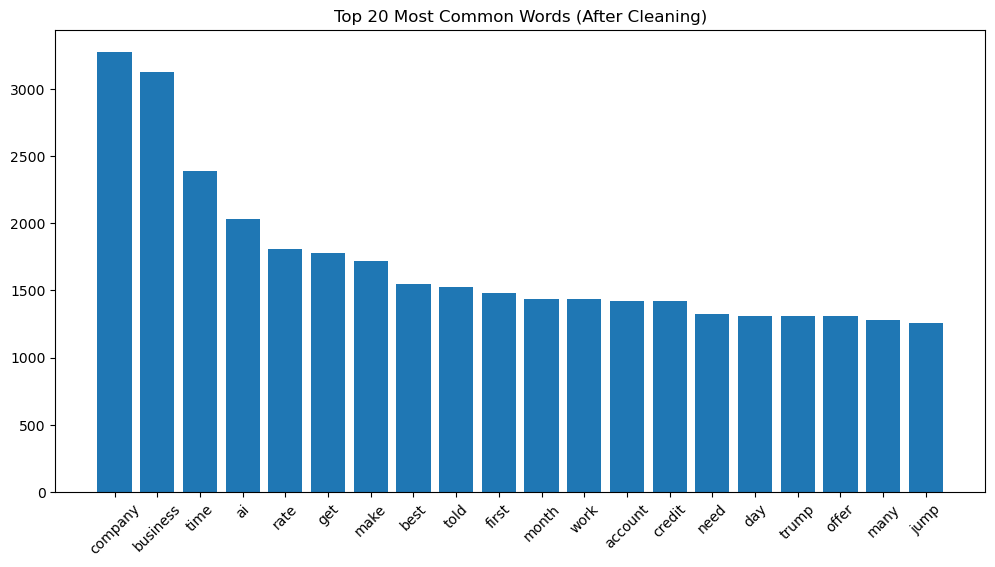

In [26]:
# Apply the cleaning function to the 'content' column and flatten the list of words
all_words = [word for content in df['Preprocessed_Content'].dropna() for word in clean_text(content)]

# Count word frequencies
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

# Prepare data for plotting
words, counts = zip(*top_words)

# Plot the top words
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title("Top 20 Most Common Words (After Cleaning)")
plt.xticks(rotation=45)
plt.savefig("us_articles_common_words.png", dpi=300)
plt.show()

# Perform Sentiment Analysis

In [27]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the content
df['Sentiment'] = df['Preprocessed_Content'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

Scraping complete. Data saved to us_articles.csv


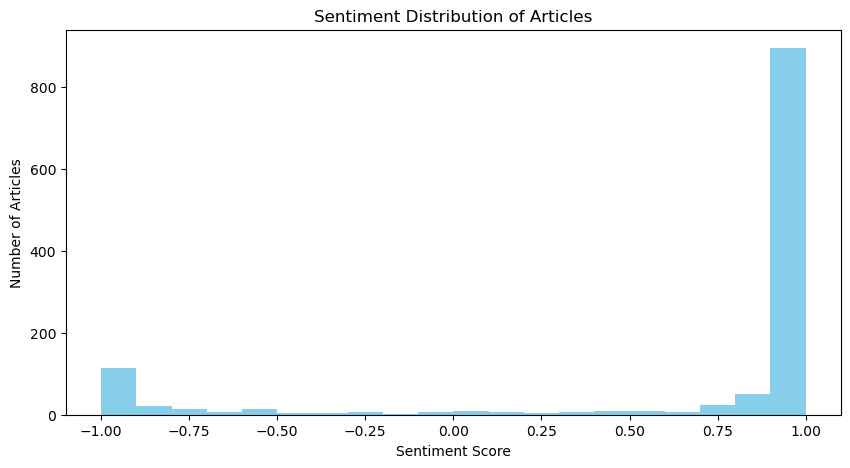

In [28]:
# Visualize the distribution of sentiments
plt.figure(figsize=(10, 5))
plt.hist(df['Sentiment'], bins=20, color='skyblue')
plt.title("Sentiment Distribution of Articles")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Articles")
plt.savefig("us_articles_sentiment_distribution.png", dpi = 300)
plt.show()

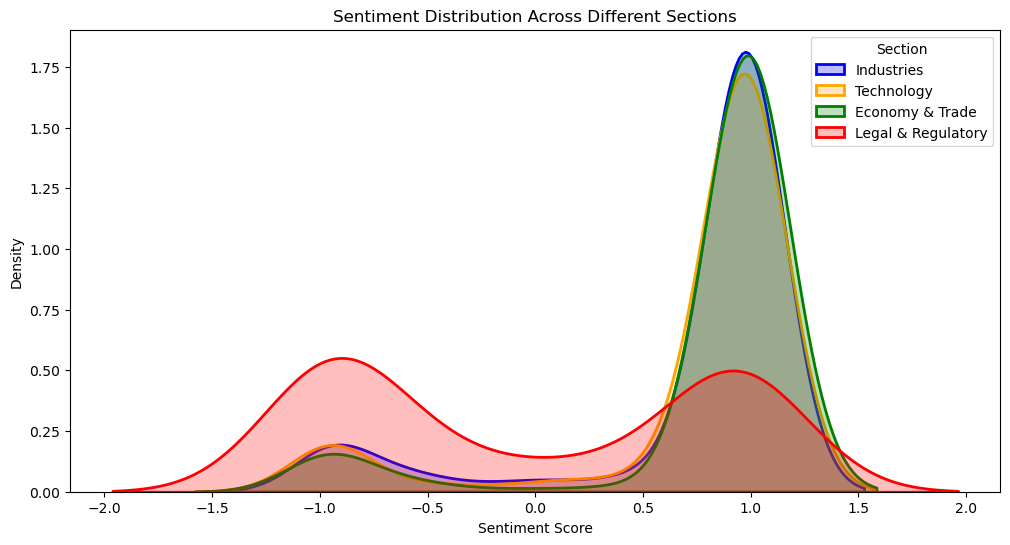

In [29]:
# Define a color palette for each new section (based on updated categories)
section_palette = {
    "Industries": "blue",
    "Technology": "orange",
    "Economy & Trade": "green",
    "Legal & Regulatory": "red",
}

# Plot sentiment distribution with KDE plots for each section
plt.figure(figsize=(12, 6))

# Plot each section separately with distinct colors and thicker lines
for section, color in section_palette.items():
    subset = df[df['Category'] == section]
    if not subset.empty:  # Skip sections without data
        sns.kdeplot(
            subset['Sentiment'], 
            label=section, 
            color=color, 
            fill=True, 
            linewidth=2  # Adjust the thickness of the lines
        )

# Add labels, title, and legend
plt.title("Sentiment Distribution Across Different Sections")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Section")
plt.savefig("us_articles_sentiment_by_section.png")
plt.show()

# Generate Word Cloud

The keyword ' AI ' appears in 250 articles.
Top topics discovered by LDA:
Topic 1: 0.010*"wa" + 0.010*"ha" + 0.007*"trump" + 0.006*"company" + 0.006*"u"
Topic 2: 0.014*"ai" + 0.013*"company" + 0.008*"ha" + 0.006*"wa" + 0.005*"business"
Topic 3: 0.017*"wa" + 0.006*"time" + 0.006*"ha" + 0.004*"told" + 0.004*"day"
Topic 4: 0.015*"rate" + 0.013*"credit" + 0.012*"account" + 0.012*"business" + 0.011*"card"
Topic 5: 0.007*"wa" + 0.006*"best" + 0.006*"ha" + 0.004*"get" + 0.004*"tv"


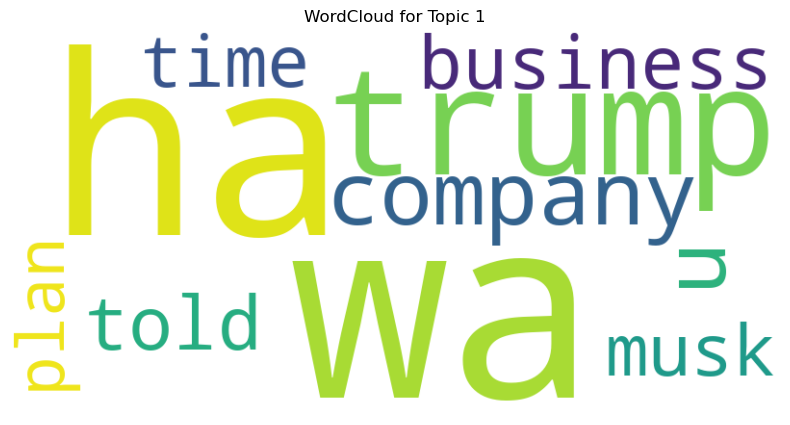

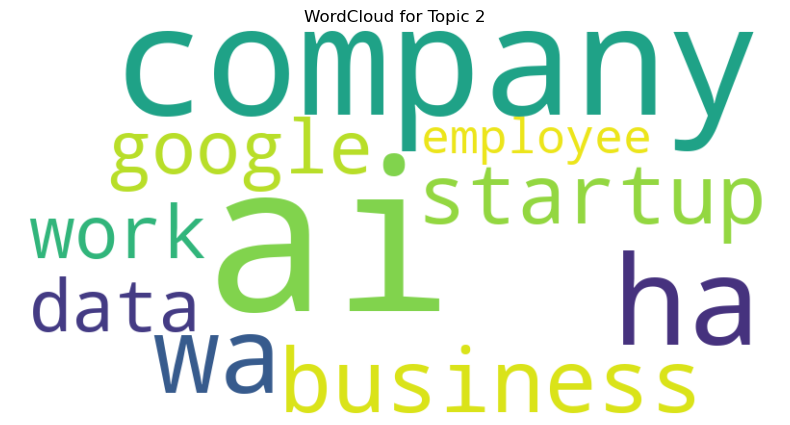

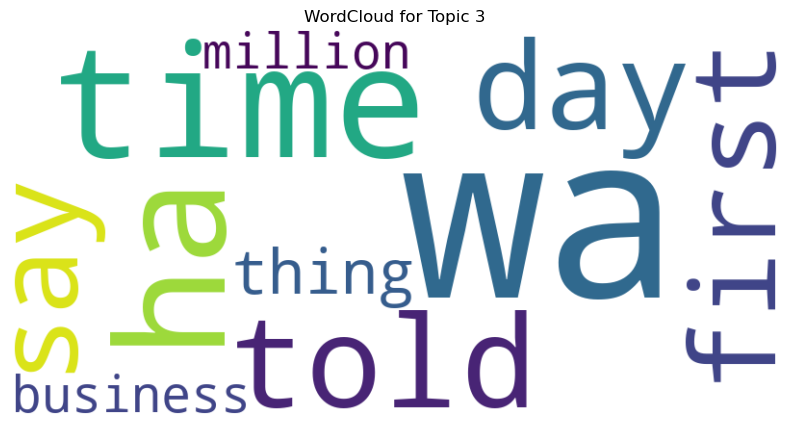

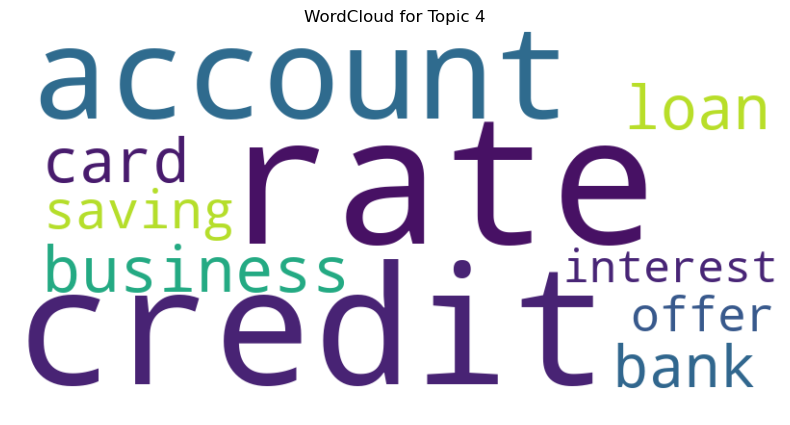

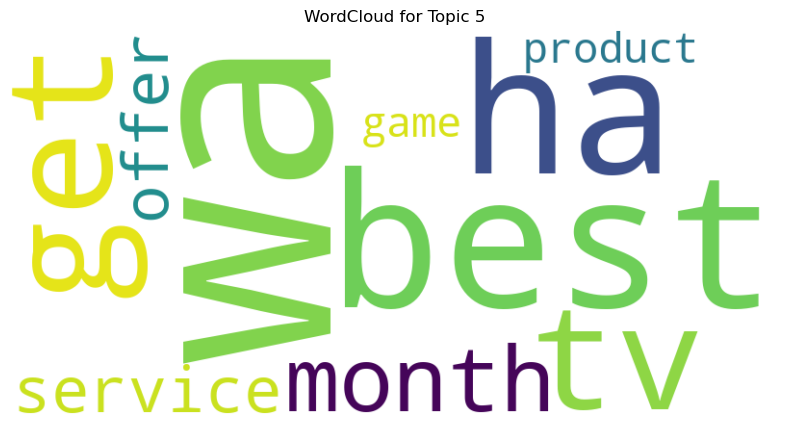

In [30]:
# Step 1: Keyword Frequency Analysis
def count_keyword_frequency(data, keyword):
    keyword_counts = df['Content'].str.contains(keyword, case=False).sum()
    print(f"The keyword '{keyword}' appears in {keyword_counts} articles.")

# Check frequency of "AI"
count_keyword_frequency(df, " AI ")

# Step 2: Preprocess content for LDA
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

df['Preprocessed_Content_List'] = df['Content'].apply(preprocess_text)

# Step 3: Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['Preprocessed_Content_List'])
corpus = [dictionary.doc2bow(text) for text in df['Preprocessed_Content_List']]

# Step 4: Apply LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Step 5: Display the topics with top words
topics = lda_model.print_topics(num_words=5)
print("Top topics discovered by LDA:")
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

# Step 6: Visualize the topics with WordCloud
for idx, topic in topics:
    words = dict(lda_model.show_topic(idx, 10))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Topic {idx + 1}")
    plt.savefig(f"us_articles_wordcloud_topic{idx + 1}", dpi=300)
    plt.show()

In [31]:
# Define technology-related terms
tech_terms = [
    "AI", "artificial intelligence", "5G", "cloud computing", "big data",
    "cybersecurity", "semiconductors", "robotics", "machine learning",
    "automation", "quantum computing", "data centers", "blockchain",
    "digital transformation", "internet of things", "innovation", "tech industry"
]

# Convert the date column to datetime format
df['DateTime'] = pd.to_datetime(df['Date'], errors='coerce')  # Handle potential date errors

# Create the month_year column based on the date
df['Month_Year'] = df['DateTime'].dt.to_period('M')

# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

df

/var/folders/47/m5xrl4k112q07z_rnn0q6wz00000gn/T/ipykernel_5033/340997174.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month_Year'] = df['DateTime'].dt.to_period('M')


Scraping complete. Data saved to us_articles.csv


,Title,Author,URL,Date,Category,Keywords,Description,Content,Preprocessed_Content,Sentiment,Preprocessed_Content_List,DateTime,Month_Year
0,A new study reveals the hidden cost of high pr...,Aki Ito,https://www.businessinsider.com/inflation-hidd...,2024-10-22T09:45:02Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Inflati...",It turns out that inflation's deepest impact i...,A new study reveals the real reason everyone i...,study reveals real reason everyone still worke...,-0.9914,"[study, reveals, real, reason, everyone, still...",2024-10-22 09:45:02+00:00,2024-10
1,I attended a self-help retreat for top female ...,Aki Ito,https://www.businessinsider.com/burnout-women-...,2024-09-08T10:03:02Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Careers...",They were burned out on being the boss. But wh...,They were burned out on being the boss. But wh...,burned bos cure reaching top aim even higher e...,0.9996,"[burned, bos, cure, reaching, top, wa, aim, ev...",2024-09-08 10:03:02+00:00,2024-09
2,It's a really bad time to be a middle manager,Aki Ito,https://www.businessinsider.com/middle-manager...,2024-12-02T09:03:01Z,Economy & Trade,"Economy, Discourse, Strategy, Careers, Tech, L...","BI studied the latest hiring numbers, and thin...",America is undergoing a rapid corporate restru...,america undergoing rapid corporate restructuri...,0.9818,"[america, undergoing, rapid, corporate, restru...",2024-12-02 09:03:01+00:00,2024-12
3,Nearly half of Americans don't want a promotion,Aki Ito,https://www.businessinsider.com/careerist-corp...,2024-10-28T09:45:01Z,Economy & Trade,"Economy, Discourse, Careers, Strategy, Tech, g...",Getting ahead was once a cornerstone of the Am...,Getting ahead was once a cornerstone of the Am...,getting ahead cornerstone american dream many ...,0.9990,"[getting, ahead, wa, cornerstone, american, dr...",2024-10-28 09:45:01+00:00,2024-10
4,The real reason so many men wind up getting pr...,Aki Ito,https://www.businessinsider.com/truth-promotio...,2024-09-24T09:27:01Z,Economy & Trade,"Economy, Careers, Strategy, Discourse, Discour...",A new study reveals that companies are picking...,A new study reveals that companies are picking...,study reveals company picking manager worst po...,0.9989,"[study, reveals, company, picking, manager, wo...",2024-09-24 09:27:01+00:00,2024-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,Tech is paying big salaries for engineering an...,Thomas Maxwell,https://www.businessinsider.com/ai-engineer-de...,2023-06-07T09:00:00Z,Technology,"Tech, Careers, Innovation, AI, Artificial Inte...",Engineers and developers with AI expertise can...,Tech companies are being pressured by investor...,tech company pressured investor cut cost respo...,0.9973,"[tech, company, pressured, investor, cut, cost...",2023-06-07 09:00:00+00:00,2023-06
1208,The CEO of AI startup Anthropic explains how h...,Thomas Maxwell,https://www.businessinsider.com/anthropic-clau...,2023-03-14T16:00:00Z,Technology,"Tech, Nordic, Innovation, ChatGPT, Generative ...","Anthropic, a competitor to the ChatGPT maker O...","While working at OpenAI, Dario Amodei spent ne...",working openai dario amodei spent nearly five ...,0.9957,"[working, openai, dario, amodei, spent, nearly...",2023-03-14 16:00:00+00:00,2023-03
1209,"Google's top AI researchers, including all the...","Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-ai-team...,2023-07-13T20:54:37Z,Technology,"Tech, Innovation, Google, Generative AI, Artif...",Google has long been a leader in AI innovation...,Editor's note: This story was originally publi...,editor note story originally published march r...,0.9888,"[editor, note, story, wa, originally, publishe...",2023-07-13 20:54:37+00:00,2023-07
1210,Leaked messages show Googlers are taking out t...,"Thomas Maxwell, Hugh Langley",https://www.businessinsider.com/google-layoffs...,2023-02-24T22:26:00Z,Technology,"Tech, Nordic, Enterprise, Innovation, Google, ...","""I'd tell you 

In [32]:
# Function to count tech terms in an article's content
def count_tech_terms(content, tech_terms):
    content = content.lower()  # Convert content to lowercase for case-insensitive matching
    term_counts = Counter()
    for term in tech_terms:
        term_counts[term] = len(re.findall(r'\b' + re.escape(term) + r'\b', content))  # Count exact matches
    return term_counts

Scraping complete. Data saved to us_articles.csv
Preprocessing complete. Updated DataFrame saved to 'us_articles_monthly_tech_terms.csv'.


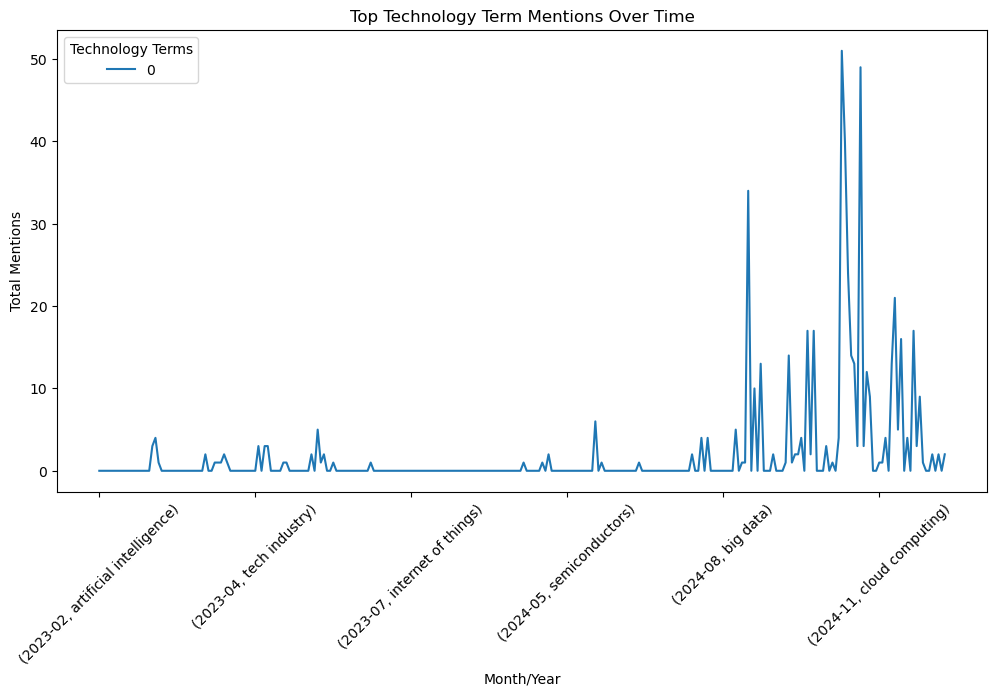

In [33]:
# Apply the function to all articles to get counts of tech terms
df['Tech_Term_Count'] = df['Content'].apply(lambda x: count_tech_terms(x, tech_terms))

# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

# Calculate monthly tech term occurrences
monthly_tech_terms = df.groupby('Month_Year')['Tech_Term_Count'].apply(
    lambda x: x.sum()  # Sum the Counter objects within each month
)

# Convert monthly_tech_terms to a DataFrame for easier plotting
monthly_tech_df = pd.DataFrame(list(monthly_tech_terms), index=monthly_tech_terms.index).fillna(0)

# Save the updated DataFrame
monthly_tech_df.to_csv('us_articles_monthly_tech_terms.csv')
print("Preprocessing complete. Updated DataFrame saved to 'us_articles_monthly_tech_terms.csv'.")

# Plot trend of technology term mentions over time for the top terms
top_terms = monthly_tech_df.sum().nlargest(10).index  # Select top 10 tech terms by total mentions
monthly_tech_df[top_terms].plot(figsize=(12, 6))
plt.title("Top Technology Term Mentions Over Time")
plt.xlabel("Month/Year")
plt.ylabel("Total Mentions")
plt.xticks(rotation=45)
plt.legend(title="Technology Terms")
plt.savefig("us_articles_monthly_tech_terms.png", dpi=300)
plt.show()

In [39]:
data = pd.read_csv("us_articles_monthly_tech_terms.csv")

# Rename columns for clarity
data.columns = ['month_year', 'technology_term', 'frequency']

# Pivot the table to make technology terms columns, month_year rows, and frequencies as values
reshaped_data = data.pivot(index='month_year', columns='technology_term', values='frequency')

# Fill NaN with 0 (if any terms are missing for a month, their frequency is 0)
reshaped_data = reshaped_data.fillna(0)

# Save the reshaped data
reshaped_data.to_csv('us_articles_monthly_tech_terms.csv')

# Preview the reshaped data
reshaped_data.tail()

technology_term,5G,AI,artificial intelligence,automation,big data,blockchain,cloud computing,cybersecurity,data centers,digital transformation,innovation,internet of things,machine learning,quantum computing,robotics,semiconductors,tech industry
month_year,,,,,,,,,,,,,,,,,
2024-08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09,0.0,0.0,5.0,1.0,0.0,0.0,2.0,34.0,13.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0
2024-10,0.0,0.0,14.0,2.0,0.0,2.0,3.0,4.0,17.0,0.0,17.0,0.0,2.0,0.0,1.0,1.0,4.0
2024-11,0.0,0.0,51.0,14.0,1.0,3.0,1.0,13.0,12.0,3.0,49.0,0.0,24.0,9.0,40.0,4.0,13.0
2024-12,0.0,0.0,21.0,0.0,0.0,3.0,2.0,4.0,9.0,0.0,17.0,0.0,16.0,1.0,5.0,2.0,2.0


In [35]:
# Vectorize the processed content
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Preprocessed_Content'])

# Define and fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}: ", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:  ['sport', 'streaming', 'live', 'service', 'home', 'game', 'price', 'plan', 'month', 'tv']
Topic 2:  ['told', 'help', 'million', 'work', 'data', 'startup', 'employee', 'business', 'ai', 'company']
Topic 3:  ['life', 'feel', 'dont', 'im', 'thing', 'want', 'make', 'day', 'best', 'time']
Topic 4:  ['fee', 'offer', 'saving', 'business', 'bank', 'card', 'loan', 'account', 'credit', 'rate']
Topic 5:  ['reported', 'jump', 'year', 'business', 'president', 'million', 'musk', 'time', 'told', 'trump']


In [40]:
# NER Function
def get_entities(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    entities = []
    for chunk in chunked:
        if isinstance(chunk, Tree):
            entity = " ".join([token for token, pos in chunk.leaves()])
            entities.append(entity)
    return entities

In [41]:
# Apply NER and extract unique entities
df['Entities'] = df['Content'].apply(get_entities)
all_entities = [entity for sublist in df['Entities'] for entity in sublist]
unique_entities = set(all_entities)

# Display some of the entities
print(f"Sample entities extracted: {list(unique_entities)[:20]}")

Sample entities extracted: ['Ark Invest', 'Amelia', 'Creole', 'Brendan Griffiths', 'Gulf', 'Revitalization Council', 'Survey Center', 'Motorola', 'RCBR', 'Carpenter', 'Heaviside', 'AppHarvest', 'Wolf Ranch', 'Space City', 'Eco Wave Power', 'Bread Savings Review Limelight Bank', 'Cash', 'Flip Pallot', 'Worksome', 'Abu Dhabi']


In [42]:
# Save to CSV
df.to_csv('us_articles.csv', index=False)
print("Scraping complete. Data saved to us_articles.csv")

Scraping complete. Data saved to us_articles.csv


In [ ]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_entities))

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("us_articles_wordcloud.png", dpi=300)
plt.show()